# Capstone Project Submission

* Student name: Carrie Liu
* Student pace: self paced
* Scheduled project review date/time: May 6, 2022 / 10:00 AM
* Instructor name: Abhineet Kulkarni
* Github URL: https://github.com/carlearn/dsc-capstone-project
* Blog post URL:

# Predicting the Market Value of FIFA Soccer Players

## Overview


Every year, EA sports will reveal its FIFA ratings for each soccer player. From sprint speed to finishing, passing accuracy to stamina, they meticulously watch what happens on the pitch to assess, judge, and evaluate players across more than 30 attributes that define a player’s skill level. Their assessments come together to create the FIFA Ratings – the authoritative ranking of over 17,000 players’ footballing ability. And more importantly, the dataset will also provide the market value and wages for each player. 

As a soccer fan, I am very excited for the rating release every year and have a strong interest in understanding what factors determine the market value of soccer players. According to FIFA's description of its' [Ratings Collective](https://www.ea.com/games/fifa/fifa-22/ratings), the overall ratings are based on the attributes. Therefore, for this project, we will focus on the prediction of players' market value using these attributes.

We will leverage the **data source** [Kaggle FIFA 22 complete player dataset](https://www.kaggle.com/datasets/stefanoleone992/fifa-22-complete-player-dataset), which covers the players data (with 100+ attributes) for the Career Mode from FIFA 15 to FIFA 22, and allows multiple comparisons for the same players across the last 8 version of the videogame. We will focus on the FIFA 2022 data sets.

Our **objective** is to build a regression model to predict the market value of soccer ball players and understand what key factors determine the market value of soccer players by what amount. 

Our **approach** will build regression models with three approaches: linear regression, random forest and XGBoost to get the best prediction of players' market value. 

## I. Import Packages and Load Data

### Import packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline

In [2]:
plt.style.use('ggplot')

In [3]:
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import make_scorer, mean_squared_error, log_loss
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, f1_score, auc

In [4]:
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

In [5]:
import warnings
warnings.filterwarnings("ignore")

### Load data

In [6]:
raw_data = pd.read_csv('Data/players_22.csv')

In [7]:
raw_data.shape

(19239, 110)

In [8]:
columns_to_drop = ['sofifa_id','player_url','short_name','long_name','overall', 'potential','dob','club_name',
                   'league_name','club_team_id','club_jersey_number','club_loaned_from','nationality_id',
                   'nation_position','nation_jersey_number','real_face','player_tags','player_traits',
                  'ls','st','rs','lw','lf','cf','rf','rw','lam','cam','ram','lm','lcm','cm','rcm','rm',
                  'lwb', 'ldm','cdm','rdm','rwb','lb','lcb','cb','rcb','rb','gk',
                  'player_face_url','club_logo_url','club_flag_url','nation_logo_url','nation_flag_url']

In [9]:
raw_data = raw_data.drop(columns_to_drop, axis=1)

In [10]:
print(raw_data.shape)
raw_data.head()

(19239, 60)


,player_positions,value_eur,wage_eur,age,height_cm,weight_kg,league_level,club_position,club_joined,club_contract_valid_until,...,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed
0,"RW, ST, CF",78000000.0,320000.0,34,170,72,1.0,RW,2021-08-10,2023.0,...,96,20,35,24,6,11,15,14,8,NaN
1,ST,119500000.0,270000.0,32,185,81,1.0,ST,2014-07-01,2023.0,...,88,35,42,19,15,6,12,8,10,NaN
2,"ST, LW",45000000.0,270000.0,36,187,83,1.0,ST,2021-08-27,2023.0,...,95,24,32,24,7,11,15,14,11,NaN
3,"LW, CAM",129000000.0,270000.0,29,175,68,1.0,LW,2017-08-03,2025.0,...,93,35,32,29,9,9,15,15,11,NaN
4,"CM, CAM",125500000.0,350000.0,30,181,70,1.0,RCM,2015-08-30,2025.0,...,89,68,65,53,15,13,5,10,13,NaN


## II. Exploratory Data Analysis

### 1. Data Cleaning

#### Check missing data

In [11]:
raw_data.isna().sum()

player_positions                   0
value_eur                         74
wage_eur                          61
age                                0
height_cm                          0
weight_kg                          0
league_level                      61
club_position                     61
club_joined                     1163
club_contract_valid_until         61
nationality_name                   0
nation_team_id                 18480
preferred_foot                     0
weak_foot                          0
skill_moves                        0
international_reputation           0
work_rate                          0
body_type                          0
release_clause_eur              1176
pace                            2132
shooting                        2132
passing                         2132
dribbling                       2132
defending                       2132
physic                          2132
attacking_crossing                 0
attacking_finishing                0
a

In [12]:
raw_data = raw_data.dropna(subset=['value_eur', 'club_joined'])

In [13]:
raw_data = raw_data.fillna(0)

#### Check data types

In [14]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18063 entries, 0 to 19238
Data columns (total 60 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   player_positions             18063 non-null  object 
 1   value_eur                    18063 non-null  float64
 2   wage_eur                     18063 non-null  float64
 3   age                          18063 non-null  int64  
 4   height_cm                    18063 non-null  int64  
 5   weight_kg                    18063 non-null  int64  
 6   league_level                 18063 non-null  float64
 7   club_position                18063 non-null  object 
 8   club_joined                  18063 non-null  object 
 9   club_contract_valid_until    18063 non-null  float64
 10  nationality_name             18063 non-null  object 
 11  nation_team_id               18063 non-null  float64
 12  preferred_foot               18063 non-null  object 
 13  weak_foot       

#### Focus on the players of level 1 league

In [15]:
raw_data.groupby('league_level').count()

,player_positions,value_eur,wage_eur,age,height_cm,weight_kg,club_position,club_joined,club_contract_valid_until,nationality_name,...,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed
league_level,,,,,,,,,,,,,,,,,,,,,
1.0,14114,14114,14114,14114,14114,14114,14114,14114,14114,14114,...,14114,14114,14114,14114,14114,14114,14114,14114,14114,14114
2.0,2318,2318,2318,2318,2318,2318,2318,2318,2318,2318,...,2318,2318,2318,2318,2318,2318,2318,2318,2318,2318
3.0,1062,1062,1062,1062,1062,1062,1062,1062,1062,1062,...,1062,1062,1062,1062,1062,1062,1062,1062,1062,1062
4.0,542,542,542,542,542,542,542,542,542,542,...,542,542,542,542,542,542,542,542,542,542
5.0,27,27,27,27,27,27,27,27,27,27,...,27,27,27,27,27,27,27,27,27,27


In [16]:
data = raw_data[raw_data.league_level == 1.0]

In [17]:
data = data.drop(['league_level'], axis=1)

#### Convert player_position into number of player_positions

In [18]:
data['count_player_positions'] = data['player_positions'].str.count(',') + 1

#### Convert club_joined and club_contract_valid_until into number of years with and left with club

In [19]:
data['year_with_club'] = 2022 - pd.DatetimeIndex(data['club_joined']).year

In [20]:
data['year_left_with_club'] = data['club_contract_valid_until'] - 2022 + 1

In [21]:
data = data.drop(['club_joined', 'club_contract_valid_until'], axis=1)

#### Convert nation_team_id into 0 and 1 to symbolize whether the players are in naiton teams

In [22]:
data['nation_team'] = data['nation_team_id'].astype(bool).astype(int)

#### Convert preferred_foot into 0 and 1 to symbolize if preferred foot is Right than 1

In [23]:
data['preferred_foot_right'] = data['preferred_foot'] == 'Right'

In [24]:
data['preferred_foot_right'] = data['preferred_foot_right'].astype(int)

#### Convert categorical features into numbers
One-hot Encoding on club_position, nationality_name, work_rate and body_type

In [25]:
one_hot_club_position = pd.get_dummies(data['club_position'], prefix = 'club_position')
one_hot_club_position.drop('club_position_CF', axis=1, inplace=True)

In [26]:
one_hot_nationality = pd.get_dummies(data['nationality_name'], prefix = 'nationality', drop_first = True)

In [27]:
one_hot_work_rate = pd.get_dummies(data['work_rate'], prefix = 'work_rate')
one_hot_work_rate.drop('work_rate_Low/Low', axis=1, inplace=True)

In [28]:
one_hot_body_type = pd.get_dummies(data['body_type'], prefix = 'body_type')
one_hot_body_type.drop('body_type_Stocky (170-)', axis=1, inplace=True)

In [29]:
df = pd.concat([data, one_hot_club_position, one_hot_nationality, one_hot_work_rate, one_hot_body_type], axis=1)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14114 entries, 0 to 19238
Columns: 263 entries, player_positions to body_type_Unique
dtypes: float64(12), int64(44), object(6), uint8(201)
memory usage: 9.5+ MB


### 2. Attributes Analysis and Data Visualization

#### Target: Value

Among the 14,114 soccer players in level 1 leagues, Kylian Mbappé has the highest market value in FIFA 2022 data with 194 million euros. The average market value is 3.3 million euros, and the median is 1 million euros. Only 18 players have the market value greater than 100 million euros, and 1,000 players have the market value greater than 10 million euros.

In [31]:
df['value_eur_mil'] = df['value_eur'] / 1000000

In [32]:
df['value_eur_mil'].describe()

count    14114.000000
mean         3.320938
std          8.663977
min          0.009000
25%          0.475000
50%          1.000000
75%          2.300000
max        194.000000
Name: value_eur_mil, dtype: float64

In [33]:
count_100mil_players = df['value_eur_mil'][df['value_eur_mil'] > 100].count()
count_100mil_players

18

In [34]:
count_10mil_players = df['value_eur_mil'][df['value_eur_mil'] > 10].count()
count_10mil_players

1000

#### Value vs Weekly Wage

There's some linearity between value and weekly wages. The higher the weekly wage of the player, the higher market value of the player.

Kevin De Bruyne and Karim Benzema have the highest weekly wages at 350K euros. The average weekly wage is 10K euros and the median is 3K euros.

In [35]:
df['wage_eur'].describe()

count     14114.000000
mean      10049.521751
std       21777.386443
min         500.000000
25%        1000.000000
50%        3000.000000
75%        9000.000000
max      350000.000000
Name: wage_eur, dtype: float64

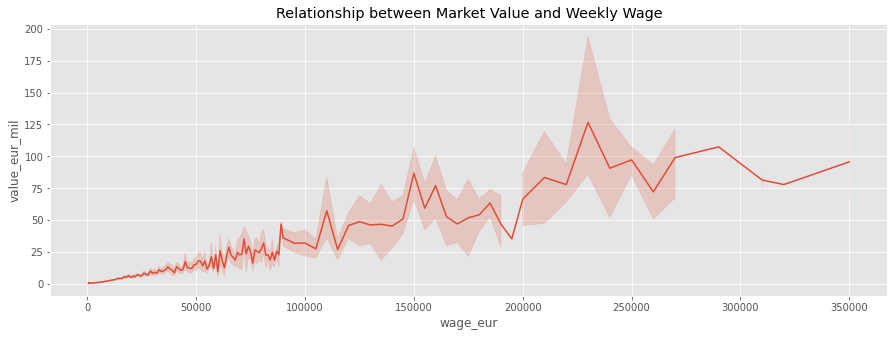

In [36]:
plt.figure(figsize=(15,5))
ax = sns.lineplot(x='wage_eur', y='value_eur_mil', data=df)
ax.set_title('Relationship between Market Value and Weekly Wage');

#### Value vs Release Clause Value

There's strong linearity between value and release clause values. The higher the release caluse values of the player, the higher market value of the player.

In [37]:
df['release_clause_eur_mil'] = df['release_clause_eur'] / 1000000

In [38]:
df['release_clause_eur_mil'].describe()

count    14114.000000
mean         6.296496
std         16.751834
min          0.016000
25%          0.788000
50%          1.700000
75%          4.300000
max        373.500000
Name: release_clause_eur_mil, dtype: float64

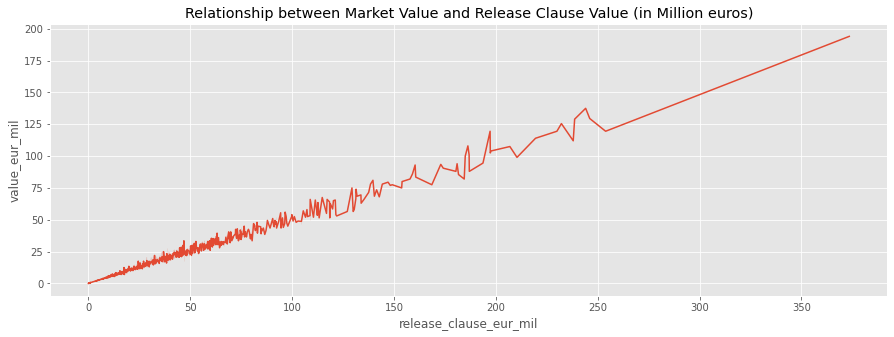

In [39]:
plt.figure(figsize=(15,5))
ax = sns.lineplot(x='release_clause_eur_mil', y='value_eur_mil', data=df)
ax.set_title('Relationship between Market Value and Release Clause Value (in Million euros)');

#### Value vs Age

There's linearity between value and age with age 30 as a cutoff.

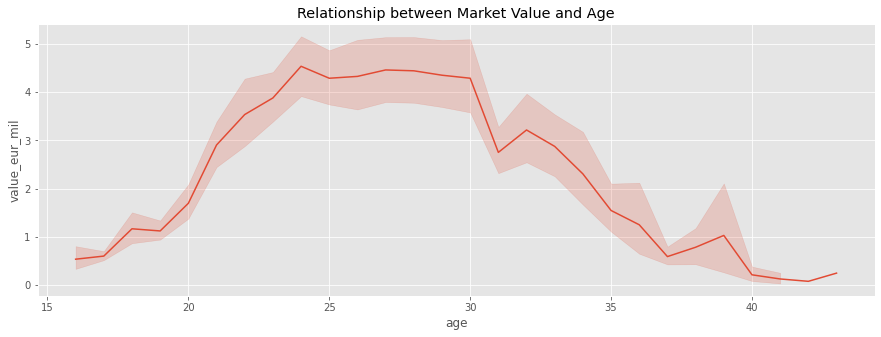

In [40]:
plt.figure(figsize=(15,5))
ax = sns.lineplot(x='age', y='value_eur_mil', data=df)
ax.set_title('Relationship between Market Value and Age');

#### Value vs Height and Weight

There's no clear relationship between market value and the height or weight of the soccer players.

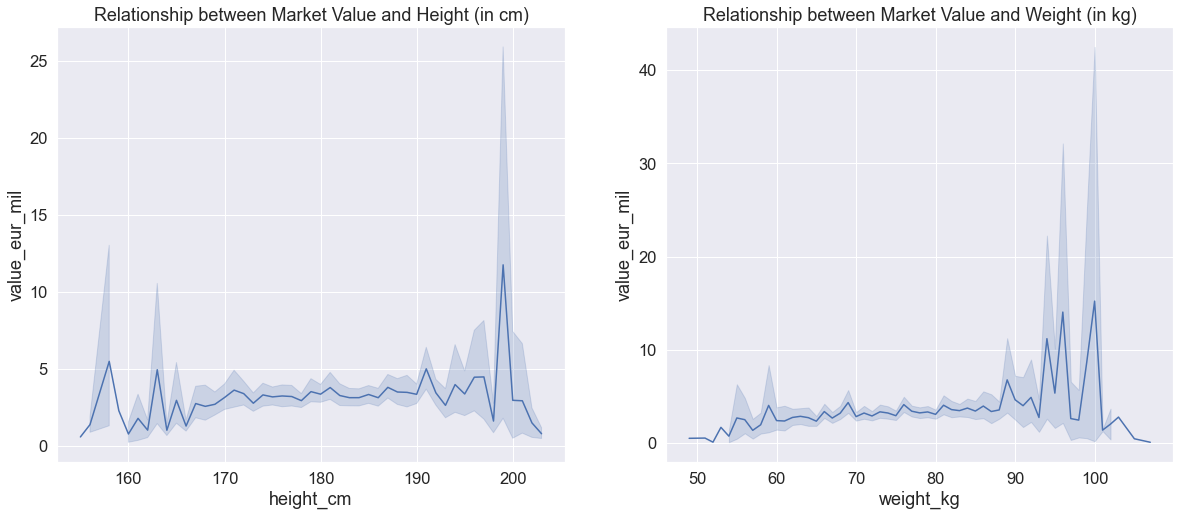

In [41]:
fig = plt.figure(figsize=(20,8))
sns.set(font_scale=1.5)

ax1 = fig.add_subplot(121)
ax1 = sns.lineplot(x='height_cm', y='value_eur_mil', data=df)
ax1.set_title('Relationship between Market Value and Height (in cm)');

ax2 = fig.add_subplot(122)
ax2 = sns.lineplot(x='weight_kg', y='value_eur_mil', data=df)
ax2.set_title('Relationship between Market Value and Weight (in kg)');

#### Value vs Time with Club

The players stayed in the club for 7 years have the highest average and median market values. On the other hand, the later the contracts end, the higher average and median market values of players.

In [42]:
df.groupby('year_with_club')['value_eur_mil'].describe()

,count,mean,std,min,25%,50%,75%,max
year_with_club,,,,,,,,
1,4992.0,2.194109,5.453243,0.015,0.42500,0.8500,1.80000,119.500
2,3388.0,2.585649,6.950617,0.015,0.42500,0.8500,1.80000,137.500
3,2376.0,3.555061,7.991262,0.015,0.52500,1.2000,2.70000,119.500
4,1298.0,4.458509,10.713813,0.015,0.57500,1.3000,3.40000,194.000
5,767.0,5.077803,11.430020,0.035,0.55000,1.4000,3.60000,129.000
6,437.0,5.788842,12.915086,0.009,0.60000,1.5000,4.30000,101.000
7,265.0,10.170094,19.664818,0.035,0.82500,2.1000,10.00000,125.500
8,210.0,7.109071,17.252583,0.050,0.60000,1.2000,4.80000,119.500
9,109.0,5.972248,14.494917,0.070,0.42500,1.2000,3.50000,90.500


In [43]:
df.groupby('year_left_with_club')['value_eur_mil'].describe()

,count,mean,std,min,25%,50%,75%,max
year_left_with_club,,,,,,,,
0.0,2038.0,0.862078,1.308686,0.015,0.275,0.525,1.0,20.5
1.0,4615.0,1.890523,5.163812,0.009,0.450,0.800,1.6,194.0
2.0,3235.0,3.608130,8.693264,0.050,0.550,1.200,2.5,119.5
3.0,2558.0,5.086005,9.992793,0.050,0.825,1.800,4.2,137.5
4.0,1255.0,6.047426,13.396029,0.040,0.500,1.500,4.4,129.0
5.0,397.0,8.903942,17.511071,0.130,0.950,2.600,8.0,119.5
6.0,14.0,38.667857,35.824205,0.350,4.725,27.750,65.5,102.5
7.0,1.0,30.000000,NaN,30.000,30.000,30.000,30.0,30.0
10.0,1.0,12.000000,NaN,12.000,12.000,12.000,12.0,12.0


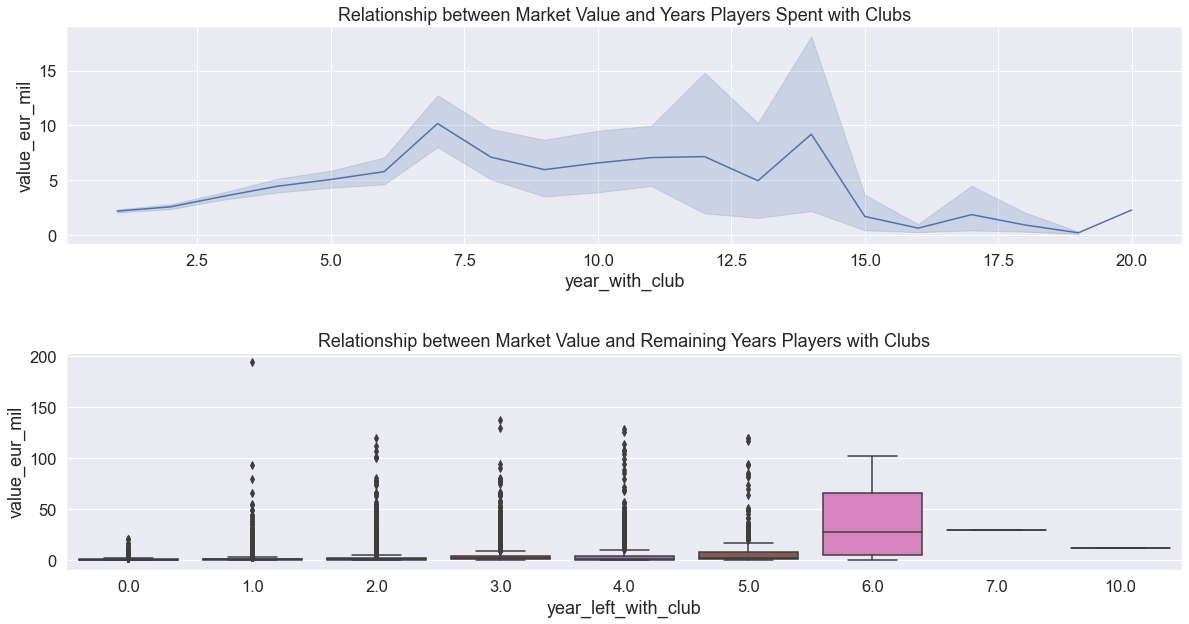

In [44]:
fig = plt.figure(figsize=(20,10))
fig.tight_layout() 
plt.subplots_adjust(hspace = 0.5)

ax1 = fig.add_subplot(211)
ax1 = sns.lineplot(x='year_with_club', y='value_eur_mil', data=df)
ax1.set_title('Relationship between Market Value and Years Players Spent with Clubs');

ax2 = fig.add_subplot(212)
ax2 = sns.boxplot(x='year_left_with_club', y='value_eur_mil', data=df, palette = 'tab10')
ax2.set_title('Relationship between Market Value and Remaining Years Players with Clubs');

#### Value vs Whether the players play in nation team

Only 4.3% of the players in the list are playing in their nation team. There's a lineary between value and nation team player. We also noticed that players who play in nation team have higher market value compared to those who do not play in nation team.

In [45]:
df['nation_team'].value_counts(normalize = True)

0    0.95671
1    0.04329
Name: nation_team, dtype: float64

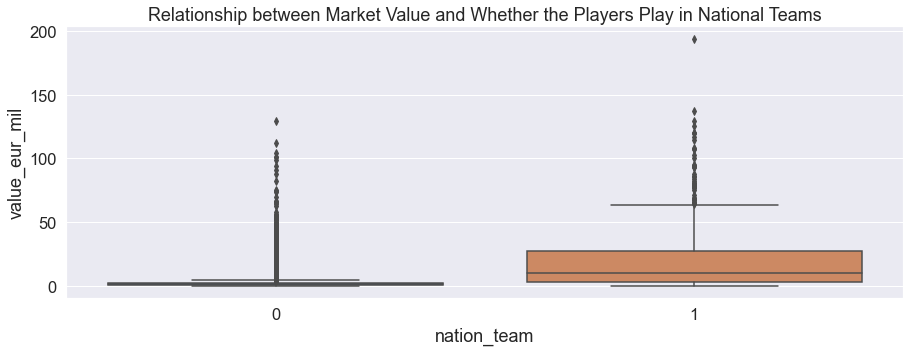

In [46]:
plt.figure(figsize=(15,5))
ax = sns.boxplot(x='nation_team', y='value_eur_mil', data=df)
ax.set_title('Relationship between Market Value and Whether the Players Play in National Teams');

#### Value vs Player's Nationality

In [47]:
df_nationality = df.groupby('nationality_name')['value_eur_mil'].describe()

In [48]:
df_nationality_20 = df_nationality.sort_values(by=['count','mean'], ascending=[False, False]).head(20)

In [49]:
df_nationality_20.reset_index(inplace=True)

In [50]:
df_nationality_20 = df_nationality_20.sort_values(by='mean', ascending=False)

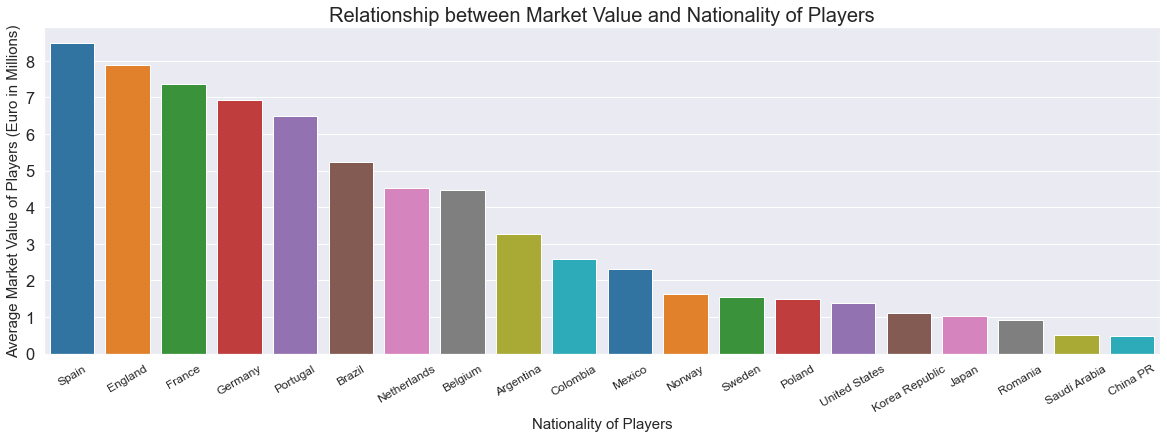

In [51]:
fig = plt.figure(figsize=(20,6))
plt.xticks(rotation = 30, fontsize = 12)
ax = sns.barplot(x='nationality_name', y='mean', data=df_nationality_20, palette = 'tab10')
ax.set_xlabel('Nationality of Players', fontsize = 15)
ax.set_ylabel('Average Market Value of Players (Euro in Millions)', fontsize = 15)
ax.set_title('Relationship between Market Value and Nationality of Players', fontsize = 20);

#### Value vs Player Position

If the players are able to play in multiple positions, the more positions they can play, the more market value. According to the visualization, Center Forward (CF) have the higher market values.

In [52]:
df.groupby('count_player_positions')['value_eur_mil'].describe()

,count,mean,std,min,25%,50%,75%,max
count_player_positions,,,,,,,,
1,6961.0,2.845725,8.208487,0.009,0.3750,0.8,1.8,137.5
2,5042.0,3.626292,8.874840,0.015,0.5500,1.2,2.6,194.0
3,2111.0,4.158626,9.485808,0.040,0.7125,1.4,3.1,119.5


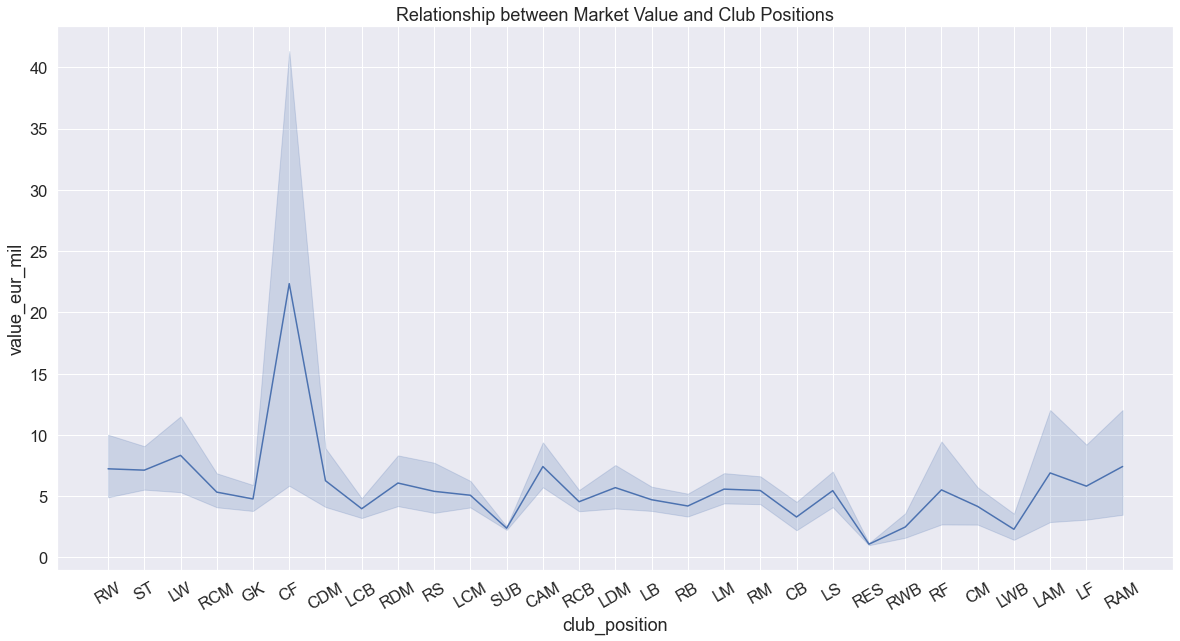

In [53]:
fig = plt.figure(figsize=(20,10))
plt.xticks(rotation=30)
ax = sns.lineplot(x='club_position', y='value_eur_mil', data=df)
ax.set_title('Relationship between Market Value and Club Positions');

#### Value vs Preferred Foot and Weak Foot

According to the [FIFAUTEAM website](https://fifauteam.com/fifa-20-weak-foot-upgrades/#:~:text=The%20Weak%20Foot%20Skill%20measures,to%20their%20preferred%20foot%20shot.), the Weak Foot Skill measures the ability of a player to shoot with one foot as he does with his preferred foot. All players have a preferred foot. Having a 5-star weak foot rating means that a player's weaker foot shot is identical to their preferred foot shot. Having a 1-star weak foot rating means that the player can only shoot OK with one foot.

⭐ 1 | 20% Value of Stats <br /> 
⭐ 2 | 40% Value of Stats <br /> 
⭐ 3 | 60% Value of Stats <br /> 
⭐ 4 | 80% Value of Stats <br /> 
⭐ 5 | 100% Value of Stats <br /> 

In [54]:
df_pf = df.groupby('preferred_foot')['value_eur_mil'].describe()
df_pf

,count,mean,std,min,25%,50%,75%,max
preferred_foot,,,,,,,,
Left,3329.0,3.674411,8.945690,0.015,0.525,1.100,2.6,137.5
Right,10785.0,3.211831,8.572632,0.009,0.450,0.975,2.2,194.0


In [55]:
df['weak_foot'].value_counts(normalize = True)

3    0.605781
2    0.219569
4    0.150064
5    0.015800
1    0.008786
Name: weak_foot, dtype: float64

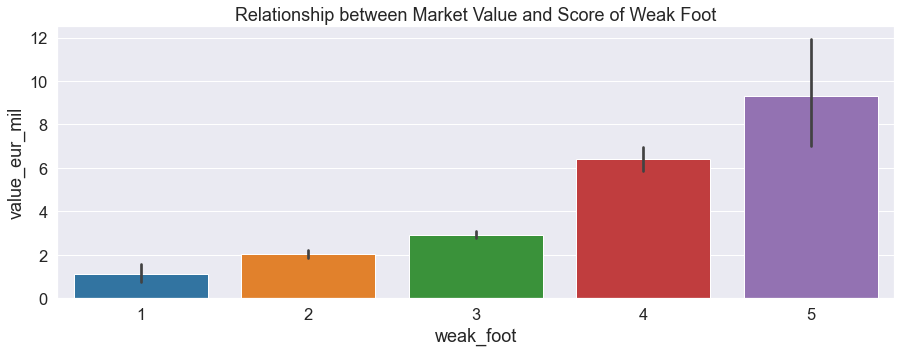

In [56]:
plt.figure(figsize=(15,5))
ax = sns.barplot(x='weak_foot', y='value_eur_mil', data=df, palette = 'tab10')
ax.set_title('Relationship between Market Value and Score of Weak Foot');

#### Value vs Body Type

129 players have unique body type. These players have higher average and median market values compared with players with other body types. 

In [57]:
df.groupby('body_type')['value_eur_mil'].describe()

,count,mean,std,min,25%,50%,75%,max
body_type,,,,,,,,
Lean (170-),391.0,1.745972,3.003305,0.070,0.40000,0.825,1.700,30.5
Lean (170-185),2957.0,3.020272,7.341805,0.035,0.45000,0.950,2.200,108.0
Lean (185+),1314.0,3.053360,6.487363,0.040,0.45000,0.975,2.275,66.0
Normal (170-),559.0,2.661583,5.655297,0.060,0.50000,1.100,2.100,63.5
Normal (170-185),5019.0,2.673938,5.656483,0.015,0.47500,1.000,2.200,90.5
Normal (185+),3022.0,2.869747,6.375108,0.015,0.47500,0.925,2.100,102.5
Stocky (170-),76.0,2.915921,4.156606,0.190,0.74375,1.450,2.325,21.5
Stocky (170-185),419.0,3.592649,6.686168,0.060,0.57500,1.400,3.000,48.5
Stocky (185+),228.0,3.854184,7.958620,0.009,0.41875,1.200,3.000,64.0


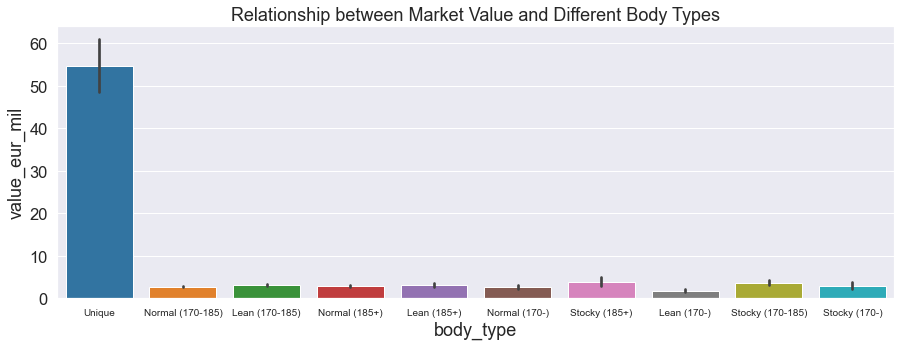

In [58]:
plt.figure(figsize=(15,5))
ax = sns.barplot(x='body_type', y='value_eur_mil', data=df, palette = 'tab10')
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 10)
ax.set_title('Relationship between Market Value and Different Body Types');

#### Value vs Work Rate

What are work rates? Work Rates dictate where players position themselves on the pitch. It is the rate of a player’s behavior on the pitch in terms of attacking and defensive works. The Work Rate is defined for Attacking (Attacking Work Rate – Abbreviated as AWR) and Defensive (Defensive Work Rate – Abbreviated as DWR) and rated between low, medium, and high, which defines how a player puts effort into participates in attacks and defenses even when they are out of position. The players with High/High work rate have higher market values.

In [59]:
df.groupby('work_rate')['value_eur_mil'].describe()

,count,mean,std,min,25%,50%,75%,max
work_rate,,,,,,,,
High/High,837.0,7.425185,14.398931,0.015,0.975,2.200,6.50,137.5
High/Low,646.0,3.826455,10.330220,0.035,0.675,1.300,3.00,194.0
High/Medium,2624.0,4.953544,11.330553,0.060,0.725,1.500,3.50,129.0
Low/High,353.0,2.580099,5.271463,0.015,0.450,0.975,2.10,46.0
Low/Low,35.0,2.358286,6.269615,0.070,0.100,0.575,1.45,34.5
Low/Medium,345.0,1.741928,3.280191,0.040,0.450,0.825,1.60,30.0
Medium/High,1407.0,3.934001,9.440825,0.045,0.575,1.100,2.70,102.5
Medium/Low,600.0,2.598175,5.963034,0.045,0.525,1.100,2.20,78.0
Medium/Medium,7267.0,2.270334,6.294032,0.009,0.375,0.750,1.60,119.5


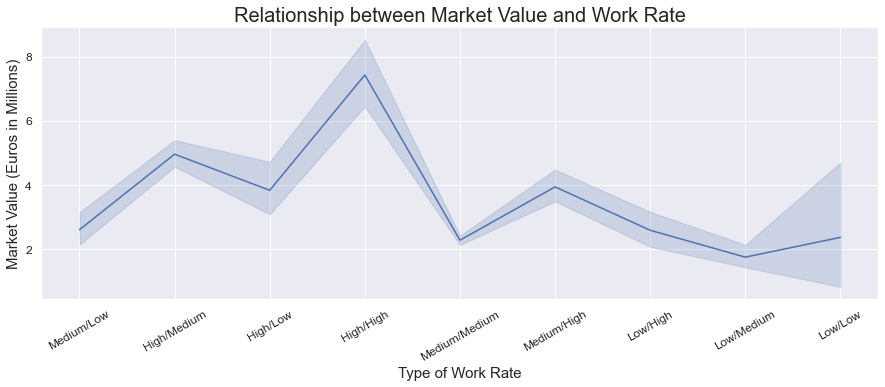

In [60]:
plt.figure(figsize=(15,5))
plt.xticks(rotation=30, fontsize = 12)
plt.yticks(fontsize = 12)
ax = sns.lineplot(x='work_rate', y='value_eur_mil', data=df)
ax.set_xlabel('Type of Work Rate', fontsize = 15)
ax.set_ylabel('Market Value (Euros in Millions)', fontsize = 15)
ax.set_title('Relationship between Market Value and Work Rate', fontsize = 20);

#### Value vs Skill Moves

The higher ranking of the skill moves, the higher market values (except 2-start skill moves). Only 52 players have 5 stars ranking, with an average market value of 32 million euros.

In [61]:
df.groupby('skill_moves')['value_eur_mil'].describe()

,count,mean,std,min,25%,50%,75%,max
skill_moves,,,,,,,,
1,1619.0,2.188480,7.487496,0.009,0.240,0.50,1.300,119.5
2,6859.0,1.712739,4.728848,0.015,0.375,0.70,1.400,102.5
3,4604.0,3.949809,8.403352,0.015,0.825,1.60,3.100,137.5
4,980.0,11.985888,16.913875,0.090,1.975,5.25,15.500,125.5
5,52.0,31.726923,37.839639,0.425,5.875,16.75,47.125,194.0


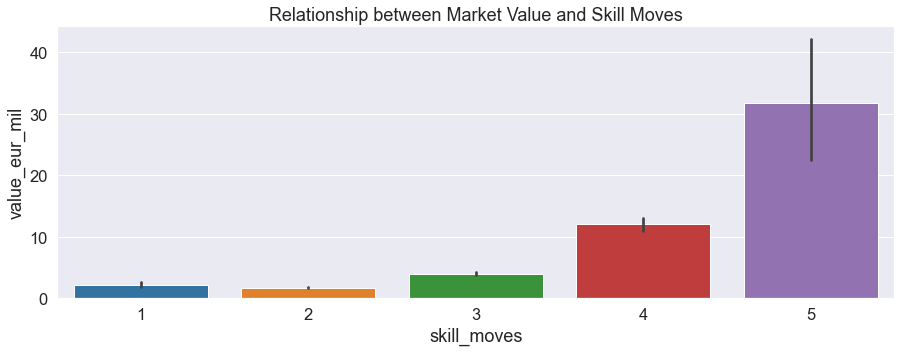

In [62]:
plt.figure(figsize=(15,5))
ax = sns.barplot(x='skill_moves', y='value_eur_mil', data=df, palette = 'tab10')
ax.set_title('Relationship between Market Value and Skill Moves');

#### Value vs International Reputation

The higher international reputation earned by the players, the higher market value of the players. Only 8 players have 5 star international reputations, and their average market value is 69.5 million euros, much higher than others. 

In [63]:
df.groupby('international_reputation')['value_eur_mil'].describe()

,count,mean,std,min,25%,50%,75%,max
international_reputation,,,,,,,,
1,12859.0,1.888810,3.539421,0.009,0.450,0.875,1.800,68.5
2,924.0,12.330931,13.007167,0.110,2.800,7.500,17.500,82.0
3,268.0,28.577332,25.897340,0.325,7.875,23.250,40.750,119.5
4,55.0,54.090909,42.737581,3.500,16.750,44.000,85.750,194.0
5,8.0,69.500000,46.759262,13.500,37.000,61.500,113.875,129.0


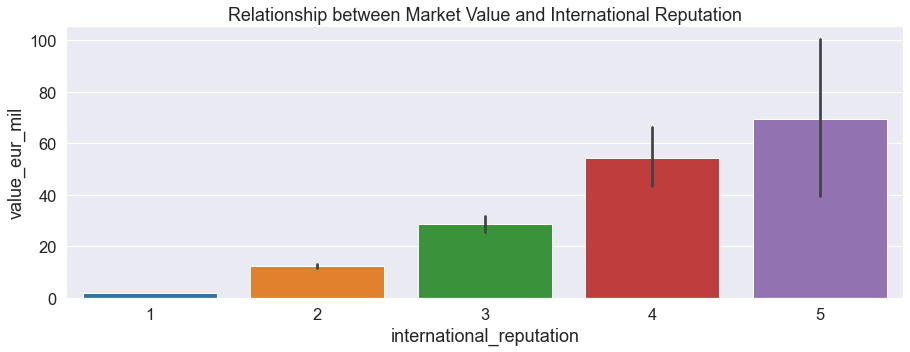

In [64]:
plt.figure(figsize=(15,5))
ax = sns.barplot(x='international_reputation', y='value_eur_mil', data=df, palette = 'tab10')
ax.set_title('Relationship between Market Value and International Reputation');

#### Value vs Players Attributes

We selected 40 players attributes in FIFA data table, including the most popular ones: pace, shooting, passing, dribbling, defending and physic. It will be a complicated combination to determine the relationship of value and players attributes. We will have a deep dive into the feature importance in our next step: modeling.

## III. Modeling - Regression Analysis

In [65]:
#drop duplicated columns and columns with one-hot encoding
df.drop(['value_eur', 'release_clause_eur_mil','player_positions', 'preferred_foot',
         'club_position', 'nationality_name', 'work_rate', 'body_type'], 
        axis=1, inplace = True)

In [66]:
list(df.columns)

['wage_eur',
 'age',
 'height_cm',
 'weight_kg',
 'nation_team_id',
 'weak_foot',
 'skill_moves',
 'international_reputation',
 'release_clause_eur',
 'pace',
 'shooting',
 'passing',
 'dribbling',
 'defending',
 'physic',
 'attacking_crossing',
 'attacking_finishing',
 'attacking_heading_accuracy',
 'attacking_short_passing',
 'attacking_volleys',
 'skill_dribbling',
 'skill_curve',
 'skill_fk_accuracy',
 'skill_long_passing',
 'skill_ball_control',
 'movement_acceleration',
 'movement_sprint_speed',
 'movement_agility',
 'movement_reactions',
 'movement_balance',
 'power_shot_power',
 'power_jumping',
 'power_stamina',
 'power_strength',
 'power_long_shots',
 'mentality_aggression',
 'mentality_interceptions',
 'mentality_positioning',
 'mentality_vision',
 'mentality_penalties',
 'mentality_composure',
 'defending_marking_awareness',
 'defending_standing_tackle',
 'defending_sliding_tackle',
 'goalkeeping_diving',
 'goalkeeping_handling',
 'goalkeeping_kicking',
 'goalkeeping_positi

### 1. Baseline Model - Linear Regression

In [67]:
x_cols = list(df.drop(['value_eur_mil'], axis=1).columns)

In [68]:
X = df[x_cols]
y = df['value_eur_mil']

In [69]:
# Split the data into training and test sets. Use the default split size
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, shuffle = True)
# A brief preview of our train test split
print(len(X_train), len(X_test), len(y_train), len(y_test))

10585 3529 10585 3529


#### 1.1 Baseline Model

In [70]:
# alwasy have a y-intercept
X_train_bm = sm.add_constant(X_train)
X_test_bm = sm.add_constant(X_test)

In [71]:
# Fitting the actual model
model_bm = sm.OLS(y_train, X_train_bm)
results_bm = model_bm.fit()
print(results_bm.summary())

                            OLS Regression Results                            
Dep. Variable:          value_eur_mil   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     5978.
Date:                Fri, 29 Apr 2022   Prob (F-statistic):               0.00
Time:                        11:22:11   Log-Likelihood:                -11584.
No. Observations:               10585   AIC:                         2.367e+04
Df Residuals:                   10332   BIC:                         2.551e+04
Df Model:                         252                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [72]:
#baseline model validation
bm_score = results_bm.rsquared_adj
bm_score

0.9930222817110853

In [73]:
# Calculate predictions on training and test sets
y_hat_train = results_bm.predict(X_train_bm)
y_hat_test = results_bm.predict(X_test_bm) 

In [74]:
# Calculate training and test residuals
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [75]:
# Calculate training and test MSE
train_mse_bm = mean_squared_error(y_train, y_hat_train)
test_mse_bm = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error of Baseline Model:', train_mse_bm)
print('Test Mean Squarred Error of Baseline Model:', test_mse_bm)

Train Mean Squarred Error of Baseline Model: 0.5224762478237284
Test Mean Squarred Error of Baseline Model: 0.6484958182723024


In [76]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [77]:
# Calculate training and test RMSE
train_rmse_bm = rmse(y_hat_train, y_train)
test_rmse_bm = rmse(y_hat_test, y_test)
print('Train Root Mean Squarred Error of Baseline Model:', train_rmse_bm)
print('Test Root Mean Squarred Error of Baseline Model:', test_rmse_bm)

Train Root Mean Squarred Error of Baseline Model: 0.7228251848294499
Test Root Mean Squarred Error of Baseline Model: 0.8052923806123478


#### 1.2 Baseline Model - Refine 1 (remove uninfluential features by stepwise selection with p-values) 

In [78]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ 
    Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(included[worst_feature])
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [79]:
feat = stepwise_selection(X, y, verbose = True)
print('resulting features:')
print(feat)

Add  nation_team                    with p-value 0.0
Add  body_type_Unique               with p-value 0.0
Add  wage_eur                       with p-value 0.0
Add  release_clause_eur             with p-value 0.0
Add  international_reputation       with p-value 5.13932e-110
Add  nationality_Spain              with p-value 2.7209e-99
Add  power_stamina                  with p-value 1.92483e-29
Add  club_position_CAM              with p-value 1.58973e-17
Add  nationality_France             with p-value 5.162e-17
Add  nationality_Portugal           with p-value 3.60252e-17
Add  nationality_England            with p-value 1.99118e-17
Add  year_left_with_club            with p-value 1.98814e-11
Add  nationality_Ukraine            with p-value 1.25791e-10
Add  club_position_SUB              with p-value 5.42503e-10
Add  goalkeeping_kicking            with p-value 3.55387e-08
Add  nationality_Italy              with p-value 3.74271e-08
Add  nationality_Netherlands        with p-value 7.88582e-

In [80]:
drop_col = list(set(df[x_cols])-set(feat))
drop_col

['attacking_crossing',
 'nationality_Ecuador',
 'club_position_LB',
 'nationality_Croatia',
 'nationality_United States',
 'nationality_Israel',
 'nationality_Morocco',
 'nationality_Thailand',
 'body_type_Normal (170-185)',
 'nationality_Senegal',
 'nationality_Indonesia',
 'nationality_Guinea',
 'nationality_Bulgaria',
 'nationality_Haiti',
 'age',
 'nationality_Guinea Bissau',
 'nationality_Belarus',
 'work_rate_Medium/Low',
 'nationality_Montserrat',
 'nationality_Mauritania',
 'nationality_Puerto Rico',
 'nationality_United Arab Emirates',
 'body_type_Lean (170-)',
 'weight_kg',
 'nationality_Namibia',
 'nationality_Paraguay',
 'nationality_Malta',
 'nationality_Chad',
 'nationality_Guatemala',
 'attacking_heading_accuracy',
 'body_type_Lean (170-185)',
 'nationality_Syria',
 'goalkeeping_positioning',
 'nationality_North Macedonia',
 'skill_dribbling',
 'nationality_Kenya',
 'movement_agility',
 'work_rate_High/Medium',
 'nationality_Eritrea',
 'mentality_vision',
 'nationality_E

In [81]:
X_train_m1 = X_train.drop(drop_col, axis = 1)
X_test_m1 = X_test.drop(drop_col, axis = 1)

In [82]:
X_train_m1 = sm.add_constant(X_train_m1)
X_test_m1 = sm.add_constant(X_test_m1)

In [83]:
# Fitting the actual model
model_m1 = sm.OLS(y_train, X_train_m1)
results_m1 = model_m1.fit()
print(results_m1.summary())

                            OLS Regression Results                            
Dep. Variable:          value_eur_mil   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                 4.075e+04
Date:                Fri, 29 Apr 2022   Prob (F-statistic):               0.00
Time:                        11:26:47   Log-Likelihood:                -11688.
No. Observations:               10585   AIC:                         2.345e+04
Df Residuals:                   10547   BIC:                         2.373e+04
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [84]:
#refined model 1 validation
m1_score = results_m1.rsquared_adj
m1_score

0.9930287948349429

In [85]:
y_hat_train_m1 = results_m1.predict(X_train_m1)
y_hat_test_m1 = results_m1.predict(X_test_m1)

In [86]:
train_rmse_m1 = rmse(y_hat_train_m1, y_train)
test_rmse_m1 = rmse(y_hat_test_m1, y_test)
print('Train Root Mean Squarred Error of Refined Model #1:', train_rmse_m1)
print('Test Root Mean Squarred Error of Refined Model #1:', test_rmse_m1)

Train Root Mean Squarred Error of Refined Model #1: 0.7299662256961565
Test Root Mean Squarred Error of Refined Model #1: 0.8015584701716123


#### 1.3 Baseline Model - Refine2 (scale the predictors based on Baseline Model)

Scaling the Predictors: Since the features are in different scale, we want to scale the features before we train the model

In [87]:
# Create the Scaler object
scaler = MinMaxScaler()
X_train_features = scaler.fit_transform(X_train)
X_test_features = scaler.fit_transform(X_test)

In [88]:
X_train_m2 = pd.DataFrame(X_train_features, index=X_train.index, columns=X_train.columns)
X_test_m2 = pd.DataFrame(X_test_features, index=X_test.index, columns=X_test.columns)

In [89]:
X_train_m2 = sm.add_constant(X_train_m2)
X_test_m2 = sm.add_constant(X_test_m2)

In [90]:
#Fitting the actual model
model_m2 = sm.OLS(y_train, X_train_m2)
results_m2 = model_m2.fit()
print(results_m2.summary())

                            OLS Regression Results                            
Dep. Variable:          value_eur_mil   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     5978.
Date:                Fri, 29 Apr 2022   Prob (F-statistic):               0.00
Time:                        11:26:48   Log-Likelihood:                -11584.
No. Observations:               10585   AIC:                         2.367e+04
Df Residuals:                   10332   BIC:                         2.551e+04
Df Model:                         252                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [91]:
#refined baseline model 2 validation
m2_score = results_m2.rsquared_adj
m2_score

0.9930222817110853

In [92]:
y_hat_train_m2 = results_m2.predict(X_train_m2)
y_hat_test_m2 = results_m2.predict(X_test_m2)

In [93]:
train_rmse_m2 = rmse(y_hat_train_m2, y_train)
test_rmse_m2 = rmse(y_hat_test_m2, y_test)
print('Train Root Mean Squarred Error of Refined Model #2:', train_rmse_m2)
print('Test Root Mean Squarred Error of Refined Model #2:', test_rmse_m2)

Train Root Mean Squarred Error of Refined Model #2: 0.72282518482945
Test Root Mean Squarred Error of Refined Model #2: 4.025285069887002


#### 1.4 Baseline Model Summary Table

In [94]:
pd.set_option('display.float_format', '{:.6f}'.format)
pd.DataFrame([[bm_score, m1_score, m2_score],
              [train_rmse_bm, train_rmse_m1, train_rmse_m2],
              [test_rmse_bm, test_rmse_m1, test_rmse_m2]], 
             columns = ['Baseline Model', 'Model 1', 'Model 2'],
             index = ['Adj R Squared', 'RMSE_train', 'RMSE_test'])

,Baseline Model,Model 1,Model 2
Adj R Squared,0.993022,0.993029,0.993022
RMSE_train,0.722825,0.729966,0.722825
RMSE_test,0.805292,0.801558,4.025285


Comments: We noticed that refined baseline model 2 had the best training results, but it was overfitted. Refined baseline model 1 is the best linear regression model based on the lowest test error.

In [95]:
#cross validation of baseline model refinement 1 
linreg = LinearRegression()
linreg.fit(X_train_m1, y_train)
mse = make_scorer(mean_squared_error)
cv_5_train = cross_val_score(linreg, X_train_m1, y_train, cv=5, scoring=mse)
cv_5_test = cross_val_score(linreg, X_test_m1, y_test, cv=5, scoring=mse)
cv_5_train_mean = cv_5_train.mean()
cv_5_test_mean = cv_5_test.mean()
print('Train cross validation score of Model 1:', cv_5_train_mean)
print('Test cross validation score of Model 1:', cv_5_test_mean)

Train cross validation score of Model 1: 0.5526745409862847
Test cross validation score of Model 1: 0.6774484365983298


Comments: Upon the cross validation, the test MSE is larger than the train MSE, but they are close. That means our model works.

In [96]:
pd.set_option('display.float_format', '{:.2f}'.format)
params = pd.DataFrame(list(zip(X_train_m1.columns, np.transpose(results_m1.params))),
                      columns = ['features', 'Linear Regression Model'])
params = params.set_index('features') 

In [97]:
params_df = params.reindex(params['Linear Regression Model'].abs().sort_values(ascending = False).index)
params_df

,Best Linear Regression Model
features,
const,-2.05
body_type_Unique,1.38
club_position_RAM,0.89
nationality_Spain,-0.75
nationality_Ukraine,-0.58
club_position_LAM,0.51
international_reputation,0.40
nationality_Portugal,-0.39
nationality_Czech Republic,-0.33


Comments: From our selected Linear Regression Model, the most important features (except nationality-related features which also matter) that determining the market value of the soccer players are:

* Body type is Unique
* Club position is Attacking Midfielder (Right, Left and Center as ranked in order)
* High international reputation

In respect of the model validation perspective, the selected Linear Regression Model performs well:

* Adjusted R-squared: 99.3%
* RMSE for train data: 0.73
* RMSE for test data: 0.80

### 2. Random Forest Regression

In [113]:
grid_param = {"n_estimators"      : [100, 300, 500],
              "max_features"      : ["auto", "sqrt", "log2"],
              "min_samples_split" : [2,4,8],
              "bootstrap": [True, False],
              }

grid_rf = GridSearchCV(RandomForestRegressor(),
                       param_grid=grid_param,
                       scoring='r2',
                       cv=None,
                       n_jobs=3)

In [ ]:
grid_rf.fit(X_train, y_train)

In [ ]:
best_parameters = grid_rf.best_params_

print('Grid Search found the following optimal parameters for Random Forest Regression: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

In [ ]:
training_preds = grid_rf.predict(X_train)
tuned_y_preds = grid_rf.predict(X_test)
tuned_y_score = grid_rf.predict_proba(X_test_scaled)[:, 1]
fpr_tuned, tpr_tuned, thresholds_tuned = roc_curve(y_test, tuned_y_score)

### 3. XGBoost Regression

## Conclusion